In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
cf3  = np.genfromtxt('cf3.csv' , delimiter='|', filling_values=-1, names=True, dtype=None, encoding=None)
pgc_cf3 = cf3['PGC']
DM_cf3  = cf3['DM']
eDM_cf3 = cf3['eDM']
N_cf3   = cf3['N']  
C_cf3   = cf3['C']  
F_cf3   = cf3['F']
I_cf3   = cf3['I']
S_cf3   = cf3['S']
H_cf3   = cf3['H']
VVmod_cf3 = cf3['Vmod']
Ks_cf3 = cf3['Ks']

In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        table
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [4]:
table = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

ip  = table["pgc"]
p2  = table["P0_w2"]
p2p = table["P0_w2p"]
p1  = table["P0_w1"]
rs  = table["R_source"]



In [5]:
for i, id in enumerate(ip):
    
    if id==28120: #p1[i]!=0:
        delta = np.abs(p1[i]-p2[i])
#         if delta > 1.7:
        print id, p1[i], p2[i], p2p[i], '%.1f'%delta, rs[i]

            


28120 13.13 13.47 14.18 0.3 2


In [6]:
table = np.genfromtxt('DMs_EDD.csv.test' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

pgc_edd = table['pgc']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
inc   = table['inc']
Vmod_edd   = table['Vmod']
Vls_edd   = table['Vls']

DM_edd  = table['DMr']
dDM_edd = table['dDMr']


DM_edd  = table['DMi']
dDM_edd = table['dDMi']
DM_edd_raw  = table['DMi_raw']

# DM_edd  = table['DMz'] 
# dDM_edd = table['dDMz']

# dDM_edd = table['dDMz']
# DM_edd  = (table['DMr']+table['DMi']+table['DMz'])/3.

# DM_edd  = table['DM_w1']
# dDM_edd = table['dDM_w1']
# DM_edd_raw  = table['DMw1_raw']


ggg = table['ggg']
rrr = table['rrr']
iii = table['iii']
zzz = table['zzz']
w11 = table['w1']
w22 = table['w2']


Sqlt = table['Sqlt']
Wqlt = table['Wqlt']

RS = table['RS']
P0 = table['P0']


I = iii-DM_edd


W1 = w11-DM_edd
print len(pgc_edd)

g_i = ggg-iii

i_w = iii-w11

10737


In [7]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']

g = 0
for i, id in enumerate(pgc_edd):
    delta = np.abs(DMi[i]-DM_w1[i])
    if delta > 1 and Sqlt[i]>0 and Wqlt[i]>0:
        print id, Sqlt[i], Wqlt[i], DM_edd[i], DM_edd_raw[i], "%.2f"%delta, "%.2f"%P0[i], RS[i], logWimx_e[i]
        g+=1
        
print g

4539 3 4 38.42 37.61 3.95 -2.61 1 0.017
9399 5 5 33.88 33.79 1.05 2.77 2 0.007
27785 5 4 27.54 27.54 1.05 -4.27 2 0.066
28120 5 5 27.75 27.75 1.33 13.47 2 0.027
42422 4 5 26.09 26.09 3.17 -5.02 2 0.126
50782 4 5 31.88 31.84 1.34 4.76 2 0.009
72882 2 3 31.51 31.48 1.07 -1.44 1 0.021
90661 5 1 35.36 35.18 17.40 -2.99 2 0.045
90844 4 1 33.52 33.45 1.42 -0.41 2 0.034
9


In [8]:
g = 0
for i, id in enumerate(pgc_edd):
    delta = np.abs(DM_edd[i]-DM_edd_raw[i])
    if delta > 2: # id == 39573: #
        print id, Sqlt[i], Wqlt[i], DM_edd[i], DM_edd_raw[i], "%.2f"%delta, P0[i], RS[i], logWimx_e[i]
        g+=1
        
print g

0


In [9]:
drop = np.genfromtxt('TF_drop.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_drop = drop['PGC']


faint = np.genfromtxt('TF_faint.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_faint = drop['PGC']

In [10]:
logD = (DM_edd-25)/5.
logH = np.log10(Vmod_edd) - logD  

keep = pgc_edd*0.

p = 0
for i, idd in enumerate(pgc_edd):
    
    if not idd in pgc_drop and not idd in pgc_faint:
        
        keep[i] = 1
    else:
        p+=1

        
print p

474


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [11]:
indx, = np.where((logH<10) & (logH>0.5) & (Vmod_edd>4000) & (iii>0) & (I<-17) & (zzz>0)  & (rrr>0)
                 & (Sqlt>3) & (keep==1) & (logWimx>0) & (iii<100) & (DM_edd>0) & (RS>-1))

# indx, = np.where((logH<2.5) & (logH>1.5) & (Vmod_edd>0) & (w11>0) & (Wqlt>3) & 
#                  (keep==1) & (W1<-16.1))# & (logWimx>0) & (i_w<-0.3)) #  & (logWimx<10.0) & (iii>0) & (I<-17)& (Sqlt>3))

Vmod = Vmod_edd[indx]
X0 = logWimx[indx]
X1  = logWimx_e[indx]
Ye = 0.2*dDM_edd[indx]
V  = Vls_edd[indx]
Y  = logH[indx]
lgD = logD[indx]
I = I[indx]
ID = pgc_edd[indx]
DM = DM_edd[indx]
INC = inc[indx]
mag_i = iii[indx]
mag_z = zzz[indx]
GI = g_i[indx]
W1 = W1[indx]
w1_mag = w11[indx]
P = X0/X1

P0 = P0[indx]

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


11.37 81.73180654948126
11.83 79.07109391889237
12.31 75.3621441476841
12.78 75.35580399318228
13.26 74.78084783320303
13.74 74.78225339118282
14.23 74.72978424914378
14.71 73.56887253425177
15.23 70.83547896070542
15.73 66.65889731604561
16.21 58.535021392783854
16.72 59.25984210573646
17.15 61.01618049492594
17.67 45.25803194226552
Fit med: 75.06435508014432
med:  1.8754337576843998 75.06435508014432
[13.70082755 -0.01423862 -0.79733486]


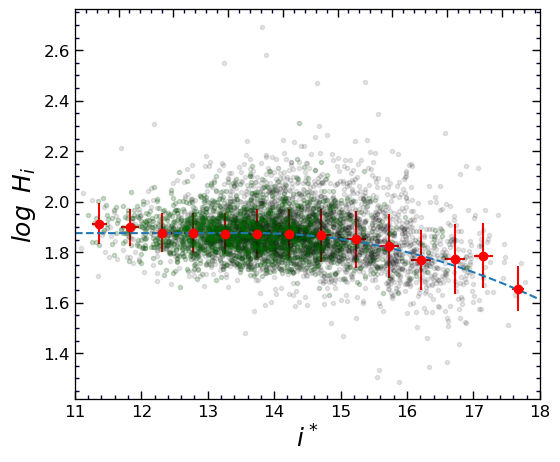

In [12]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(mag_i,Y, 'k.', alpha=0.1)
# ax.set_ylim(-0.02, 0.2)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
        
X = mag_i 


for i in np.arange(11,18,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$i^*$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 

v = np.linspace(11,18,50)


fit, cov = curve_fit(hf, X, Y, sigma=Ye)
ax.plot(v,hf(v, fit[0], fit[1], fit[2]), '--')


set_axes(ax, fontsize=12)



# y = Y[(mag_i>12) & (mag_i<15)]
# ye = Ye[(mag_i>12) & (mag_i<15)]
# print 10**np.median(Y)
# print  10**(np.sum(y/ye)/np.sum(1./ye))
# med = np.median(Y)
# print "med0= ", med, 10**med

print "Fit med:", 10**(hf(fit[0], fit[0], fit[1], fit[2]) )
med = (hf(fit[0], fit[0], fit[1], fit[2]) )


print "med: ", med, 10**med

ax.set_xlim(11,18)

print fit

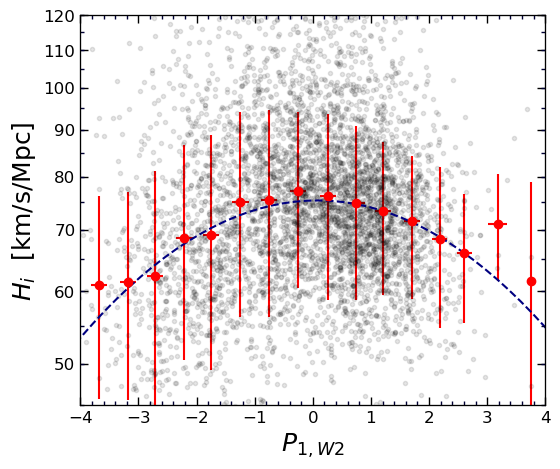

In [13]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(P0,10**Y, 'k.', alpha=0.1)

        
        
X = P0 

for i in np.arange(-4,4,0.5):
    xp = []
    yp = []
    ype = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>0:
        yp = np.asarray(yp)
        xp = np.asarray(xp)
        ype = np.asarray(ype)
        yy =  np.sum(yp/ype)/np.sum(1./ype)
        H = 10**yy
        ax.errorbar(np.median(xp), H, yerr=np.std(yp)*H*np.log(10), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     

ax.set_xlabel(r'$P_{1,W2}$', fontsize=18) 
ax.set_ylabel(r'$H_i$'+ '  [km/s/Mpc]', fontsize=18) 





v = np.linspace(-5, 5, 50)
c, cov = np.polyfit(X, Y, 2, w=1./Ye, cov=True)
ax.plot(v,10**(c[0]*v**2+c[1]*v+c[2]), '--', color='navy')



x_ax, y_ax = set_axes(ax, (-4,4), (45,120), fontsize=12) 

ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.yticks([50,60,70,80,90,100,110,120], ('50','60','70','80','90','100','110','120'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(45,120, step=10))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(10))
y_ax.yaxis.set_minor_locator(MultipleLocator(5))

In [14]:
print 10**np.median(Y)

73.44485007737674


-3.68 59.406131826347455
-3.18 61.5646912733156
-2.71 63.034213605253164
-2.21 67.41645076006405
-1.75 68.94721009828672
-1.25 74.85272322519745
-0.76 76.75485583616353
-0.25 76.8959217132841
0.26 75.92516057027835
0.75 74.51198796938561
1.21 72.9889297403041
1.71 71.17657030483934
2.18 68.34062996630091
2.61 67.89699872528429
3.18 73.80750856959358
3.76 65.30233198157723
[-9.01686564e-03  1.43453510e-03  1.87711488e+00]
1.8788499596063997 75.65714689683156
-0.009\pm0.001
0.001\pm0.001
1.877\pm0.002


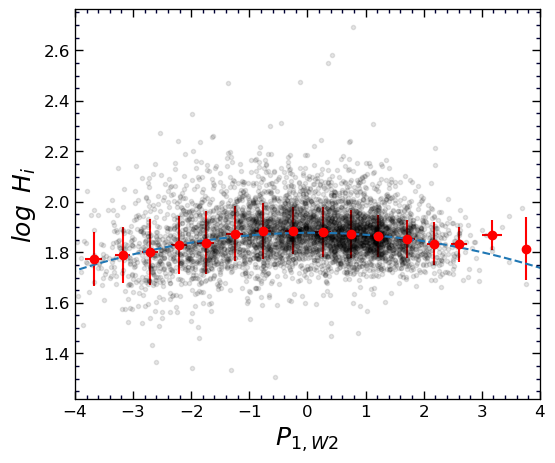

In [15]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(P0,Y, 'k.', alpha=0.1)


for i, id in enumerate(ID):
    
    if id in pgc_cf3:
        ax.plot(mag_i[i], Y[i], 'g.', alpha=0.1)  
        
        
        
X = P0 


for i in np.arange(-4,4,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel(r'$P_{1,W2}$', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_i$', fontsize=18) 




ax.set_xlim(-4,4)

v = np.linspace(-5, 5, 50)
c, cov = np.polyfit(X, Y, 2, w=1./Ye, cov=True)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], '--')

Y = Y - (c[0]*X**2+c[1]*X+c[2]) + med

print c
med = np.median(Y)
print med, 10**med


set_axes(ax, fontsize=12)


for i in range(len(c)):
        print '%.3f'%c[i]+'\pm'+'%.3f'%np.sqrt(cov[i][i])

C=  [3.41299886 1.2457588  1.85509344]
Median =  1.8788499596063997 75.65714689683156


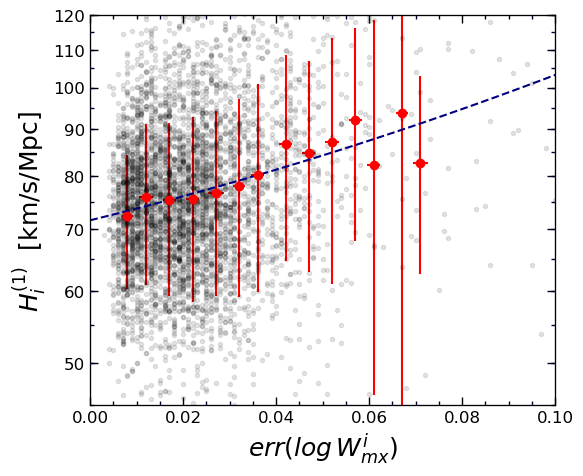

In [16]:
def fitFunc(x,m,b,c):
    
    
    y = c + 1./(m*x+b)
  
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


v = np.linspace(0,0.1,50)

X = X1

xx = X
yy = Y

c0 = np.polyfit(X[X<0.1],Y[X<0.1], 2, w=1./Ye[X<0.1])
c, cov = curve_fit(fitFunc, X[X<0.07], Y[X<0.07])

print 'C= ', c0


print 'Median = ', med,  10**med

ax.plot(X, 10**Y, 'k.', alpha=0.1)
ax.plot(v, 10**(c0[0]*v**2+c0[1]*v+c0[2]), '--', color='navy')
# ax.plot(v, 10**fitFunc(v, c[0], c[1], c[2]), '--', color='orange')


XL = []
YL = []
YLe = []
for i in np.arange(0.005,0.1,0.005):
    xp = []
    yp = []
    ype = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.005:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        
        yp = np.asarray(yp)
        xp = np.asarray(xp)
        ype = np.asarray(ype)
        yy =  np.sum(yp/ype)/np.sum(1./ype)
        H = 10**yy
        ax.errorbar(np.median(xp), H, yerr=np.std(yp)*H*np.log(10.), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6) 

        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel(r'$err(log \/ W^i_{mx})$', fontsize=18) 
ax.set_ylabel(r'$H^{(1)}_{i}$'+ '  [km/s/Mpc]', fontsize=18) 



x_ax, y_ax = set_axes(ax, (0,0.1), (45,120), fontsize=12) 

ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.yticks([50,60,70,80,90,100,110,120], ('50','60','70','80','90','100','110','120'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(45,120, step=10))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(10))
y_ax.yaxis.set_minor_locator(MultipleLocator(5))

C=  [3.41299886 1.2457588  1.85509344]
Median =  1.8788499596063997 75.65714689683156
0.008 73.1643474174872
0.012 75.31690371895624
0.017 74.79523097707623
0.022 75.0037884519248
0.027 75.08424357579037
0.032 77.54089850964193
0.036 78.39795875961406
0.042 86.11487121277041
0.047 84.29828633246065
0.052 88.28464693485863
0.057 88.0942212520362
0.061 92.16268122601821
0.067 84.57575986893518
0.071 86.29399839007748
75.65714689683156


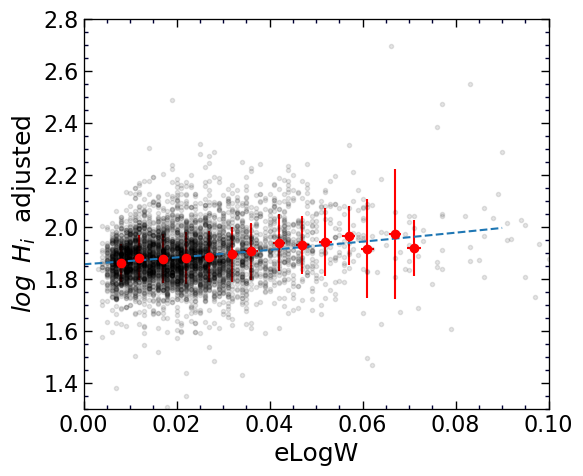

In [17]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(0,0.1)
ax.set_ylim(1.3,2.8)
v = np.linspace(0,0.09,50)

X = X1

xx = X
yy = Y

c = np.polyfit(X[X<0.1],Y[X<0.1], 2, w=1./Ye[X<0.1])


print 'C= ', c


print 'Median = ', med,  10**med

ax.plot(X, Y, 'k.', alpha=0.1)
ax.plot(v, c[0]*v**2+c[1]*v+c[2], '--')







XL = []
YL = []
YLe = []
for i in np.arange(0.005,0.08,0.005):
    xp = []
    yp = []
    ype = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.005:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        
        yp = np.asarray(yp)
        xp = np.asarray(xp)
        ype = np.asarray(ype)
        yy =  np.sum(yp/ype)/np.sum(1./ype)
        ax.errorbar(np.median(xp), yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        print np.median(xp), 10**np.median(yp)
        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel('eLogW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{i}$'+'  adjusted', fontsize=18) 



set_axes(ax)

print 10**med

Y = Y - (c[0]*X**2+c[1]*X+c[2]) + med  


2.262 80.58805901754629
2.355 77.69113854673677
2.453 76.0500640984368
2.55 73.24448057886804
2.642 72.22140866557646
2.731 72.52095440798156
[-0.11167575  2.15743717]


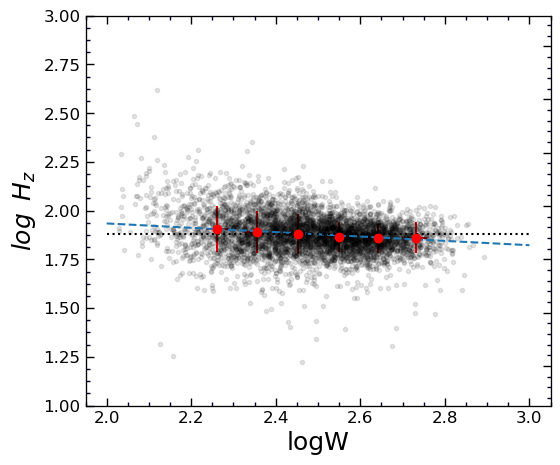

In [18]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = X0 

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(2.2,2.8,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.set_xlabel('logW', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_z$', fontsize=18) 

v = np.linspace(2,3,50)
# c = np.polyfit(XL,YL, 1, w=1./np.asarray(YLe))
c = np.polyfit(X[(X>2.2)&(X<2.8)],Y[(X>2.2)&(X<2.8)], 1, w=1./Ye[(X>2.2)&(X<2.8)])
ax.plot(v,c[0]*v+c[1], '--')


print c

set_axes(ax, fontsize=12)

# 
# Y = Y - (c[0]*X+c[1])+ med
# 

ax.set_ylim(1,3)

ax.plot([2.0, 3.0],[med, med], ':', color= 'k')

4642 75.6
5435 75.6
6494 76.7
7476 74.7
8430 76.0
9505 73.9
10441 73.5
11462 73.7
12452 73.6
13458 72.5
14583 70.9
15423 71.3
16430 74.9
17477 68.8
77.71639415298674 71.6906133916934
[-3.18639509e-06  1.90325822e+00]
1.8905126422135257
75.05127672722732
75.64030283642946


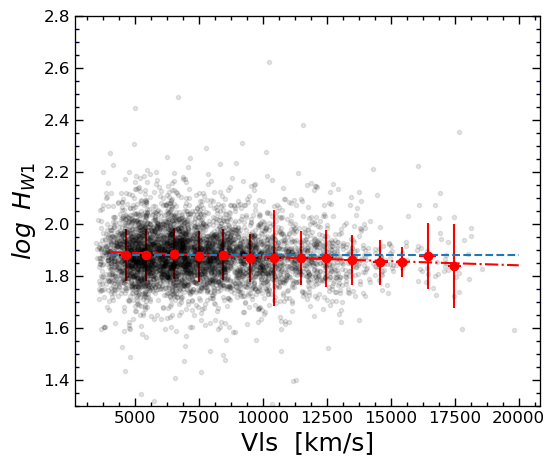

In [19]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = V

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls  [km/s]', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{W1}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
# c = np.polyfit(XL,YL, 1, w=1./np.asarray(YLe))
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1./Ye[X>4000])
ax.plot(v,c[0]*v+c[1], 'r-.')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print 10**np.median(Y)
m = (np.sum(Y[X>4000]/Ye[X>4000])/np.sum(1./Ye[X>4000]))
H0 = 10**m
print  H0

ax.plot([4000,20000], [m,m], '--')

In [20]:
len(Y)

5042

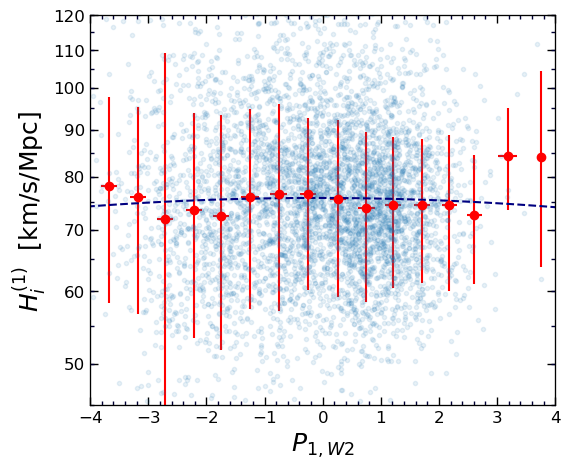

In [21]:
def hf(x,x0,a,c):
    
    y = a*x**2-2*a*x0*x+c
    
    try: 
        y[x<x0] = -a*x0**2+c
    except:
        if x<x0: y=0
    
    return y


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(P0,10**Y, '.', alpha=0.1)

        
        
X = P0 


for i in np.arange(-4,4,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        H=10**np.median(yp)
        ax.errorbar(np.median(xp), H, yerr=np.std(yp)*H*np.log(10), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     

ax.set_xlabel(r'$P_{1,W2}$', fontsize=18) 
ax.set_ylabel(r'$H^{(1)}_i$'+ '  [km/s/Mpc]', fontsize=18) 





v = np.linspace(-5, 5, 50)
c, cov = np.polyfit(X, Y, 2, w=1./Ye, cov=True)
ax.plot(v,10**(c[0]*v**2+c[1]*v+c[2]), '--', color='navy')



x_ax, y_ax = set_axes(ax, (-4,4), (45,120), fontsize=12) 

ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.yticks([50,60,70,80,90,100,110,120], ('50','60','70','80','90','100','110','120'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(45,120, step=10))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(10))
y_ax.yaxis.set_minor_locator(MultipleLocator(5))

C=  [ 4.03337898e-12 -1.07714623e-13  1.87884996e+00]
Median =  1.8788499596063997 75.65714689683156


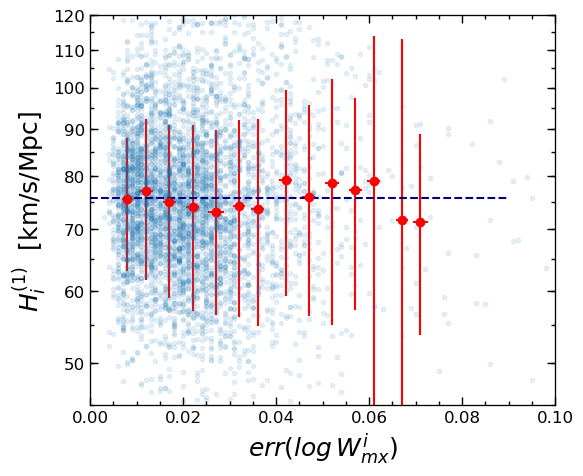

In [22]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(0,0.1)
ax.set_ylim(1.3,2.8)
v = np.linspace(0,0.09,50)

X = X1

xx = X
yy = Y

c = np.polyfit(X[X<0.1],Y[X<0.1], 2, w=1./Ye[X<0.1])


print 'C= ', c


print 'Median = ', med,  10**med

ax.plot(X, 10**Y, '.', alpha=0.1)
ax.plot(v, 10**(c[0]*v**2+c[1]*v+c[2]), '--', color='navy')


XL = []
YL = []
YLe = []
for i in np.arange(0.005,0.08,0.005):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.005:# and ID[ii] in pgc_cf3:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>10:
        sqN = np.sqrt(len(xp))
        H = 10**np.median(yp)
        ax.errorbar(np.median(xp), H, yerr=np.std(yp)*H*np.log(10.), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  

        XL.append(np.median(xp))
        YL.append(np.median(yp))
        YLe.append(np.median(np.std(yp/sqN)))

ax.set_xlabel(r'$err(log \/ W^i_{mx})$', fontsize=18) 
ax.set_ylabel(r'$H^{(1)}_{i}$'+ '  [km/s/Mpc]', fontsize=18) 



x_ax, y_ax = set_axes(ax, (0,0.1), (45,120), fontsize=12) 

ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.yticks([50,60,70,80,90,100,110,120], ('50','60','70','80','90','100','110','120'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(45,120, step=10))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(10))
y_ax.yaxis.set_minor_locator(MultipleLocator(5))

Text(0.5,0,'$DM_{cf3}$')

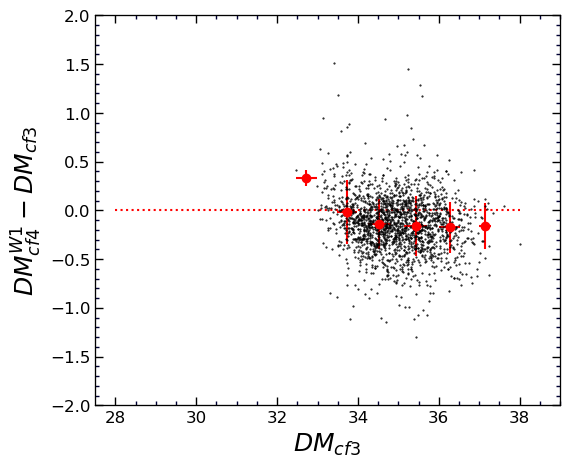

In [23]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = 5.*(np.log10(Vmod) - Y)+25.

XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:      
        ix, = np.where(ID==id)
        ax.errorbar(DM_cf3[i], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(DM_cf3[i])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(29,38,1):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)               
            

ax.set_ylabel(r'$DM^{W1}_{cf4}-DM_{cf3}$', fontsize=18)                                                 
set_axes(ax, [27.5,39],[-2,2], fontsize=12)
ax.plot([28,38],[0,0], 'r:')
ax.set_xlabel('$DM_{cf3}$', fontsize=18) 


3805.0 -0.10108350444081537
5103.0 -0.15255416175870806
6853.0 -0.14647977566608006
9014.0 -0.09507003310591244
10707.0 -0.09526688246334913
12663.0 -0.08542921022367267
14731.0 -0.06534217704142975
16905.5 -0.15760645380827398
18123.0 -0.022851400708304936
-0.13460881837717362


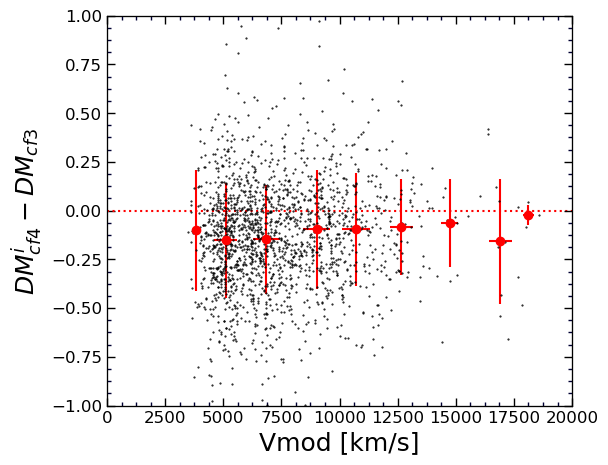

In [24]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:
        ix, = np.where(ID==id)
        ax.errorbar(V[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(V[ix][0])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)      
        print np.median(xp), np.median(yp)
            

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

# set_axes(ax, [27.5,39],[-1,1], fontsize=12)
# ax.plot([28,38],[0,0], 'r:')
# ax.set_xlabel('$DM_{cf3}$', fontsize=18) 

print np.mean(YY)

3805.0 -0.10108350444081537
5103.0 -0.15255416175870806
6853.0 -0.14647977566608006
9014.0 -0.09507003310591244
10707.0 -0.09526688246334913
12663.0 -0.08542921022367267
14731.0 -0.06534217704142975
16905.5 -0.15760645380827398
18123.0 -0.022851400708304936
-0.13460881837717362


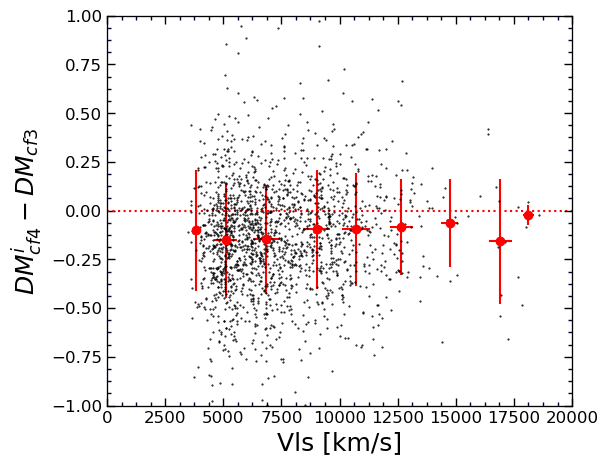

In [25]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)



XX = []
YY = []
for i, id in enumerate(pgc_cf3):
    
    if id in ID:
        ix, = np.where(ID==id)
        ax.errorbar(V[ix][0], Y[ix][0]- DM_cf3[i],  capsize=3, color='k', fmt='.' , ms=1)
        XX.append(V[ix][0])
        YY.append(Y[ix][0]- DM_cf3[i])
            
for i in np.arange(0,20000,2000):
    xp = []
    yp = []
    for ii in range(len(XX)):
        xi = XX[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(YY[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)      
        print np.median(xp), np.median(yp)
            

ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$DM^i_{cf4}-DM_{cf3}$', fontsize=18)                                                 
            
ax.plot([0,20000],[0,0], 'r:')
set_axes(ax, [0,20000],[-1,1], fontsize=12)

# set_axes(ax, [27.5,39],[-1,1], fontsize=12)
# ax.plot([28,38],[0,0], 'r:')
# ax.set_xlabel('$DM_{cf3}$', fontsize=18) 

print np.mean(YY)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


4562 73.3
5415 73.4
6559 73.5
7481 71.8
8486 71.3
9498 73.8
10508 68.8
11484 73.0
12419 68.1
13370 77.4
14389 69.2
15227 68.2
16612 75.1
17606 65.6
73.81362810824976 70.2542554881205
[-1.95126515e-06  1.87594161e+00]
1.868136552416611
2629


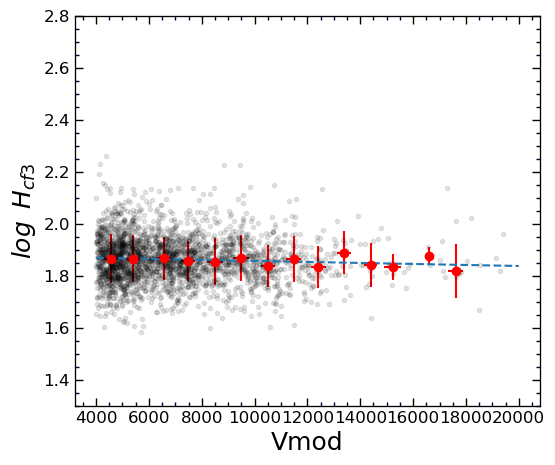

In [26]:
# pgc_edd = table['pgc']
# logWimx   = table['logWimx']
# logWimx_e = table['logWimx_e']
# inc   = table['inc']
# Vmod   = table['Vmod']

# pgc_cf3 = cf3['PGC']
# DM_cf3  = cf3['DM']
# eDM_cf3

Vmod_cf3 = []
logH_cf3 = []
eeDM_cf3 = []

for i, id in enumerate(pgc_cf3):
    
    if id in pgc_edd:      
        ix, = np.where(pgc_edd==id)
        logD_3 = (DM_cf3[i]-25)/5.
        logH_3 = np.log10(Vmod_edd[ix][0]) - logD_3
        Vmod_cf3.append(Vmod_edd[ix][0])
        logH_cf3.append(logH_3)
        eeDM_cf3.append(eDM_cf3[i])

Vmod_cf3 = np.asarray(Vmod_cf3)
logH_cf3 = np.asarray(logH_cf3)
eeDM_cf3  = np.asarray(eeDM_cf3)

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[Vmod_cf3>4000]
Y = logH_cf3[Vmod_cf3>4000]
Ye = eeDM_cf3[Vmod_cf3>4000]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vmod', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1/Ye[X>4000])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print len(Y)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


4574 73.5
5401 73.7
6541 73.0
7476 72.5
8493 73.3
9472 75.7
10497 74.7
11480 75.6
12426 76.1
13448 76.2
14432 75.4
15455 77.5
16458 76.0
17520 72.5
73.26122174854719 76.20013688855133
[1.55287223e-06 1.85866267e+00]
1.8648741569469809
8190


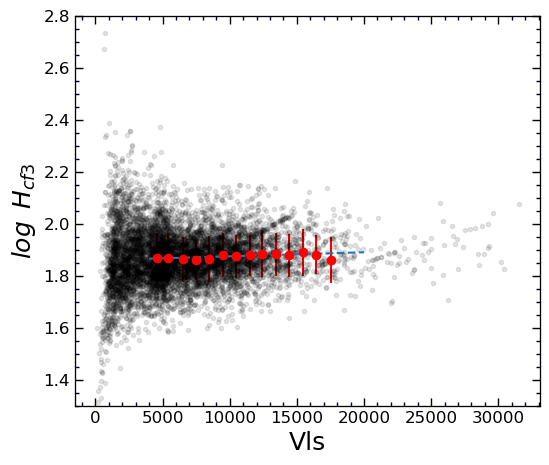

In [27]:
logD_3 = (DM_cf3-25)/5.
logH_3 = np.log10(VVmod_cf3) - logD_3

Vmod_cf3 = VVmod_cf3
logH_cf3 = logH_3
eeDM_cf3 = eDM_cf3

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[(I_cf3=='I') | (H_cf3=='H') | (F_cf3=='F')]
Y = logH_cf3[(I_cf3=='I') | (H_cf3=='H')| (F_cf3=='F')]
Ye = eeDM_cf3[(I_cf3=='I') | (H_cf3=='H')| (F_cf3=='F')]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(4000,18000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000 :
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

v = np.linspace(4000,20000,2000)
c = np.polyfit(X[X>4000],Y[X>4000], 1, w=1/Ye[X>4000])
ax.plot(v,c[0]*v+c[1], '--')


ax.set_ylim(1.3,2.8)

set_axes(ax, fontsize=12)

print 10**(c[0]*4000.+c[1]), 10**(c[0]*15000.+c[1])
print c
print c[0]*4000.+c[1]

print len(Y)

5 90.7
6 nan
7 nan
8 72.5
9 71.7
10 72.7
11 nan
12 74.0


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/ehsan/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


(5, 15)

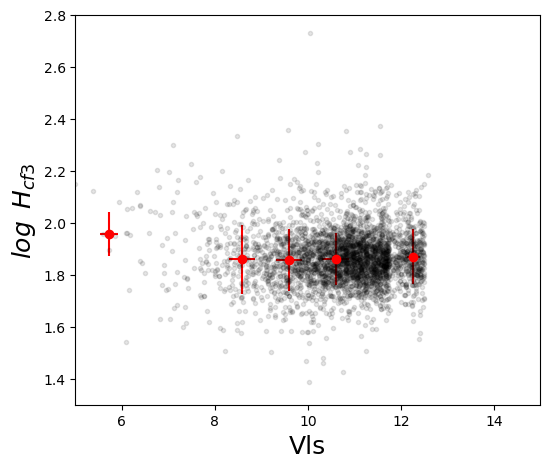

In [28]:
logD_3 = (DM_cf3-25)/5.
logH_3 = np.log10(VVmod_cf3) - logD_3

Vmod_cf3 = Ks_cf3
logH_cf3 = logH_3
eeDM_cf3 = eDM_cf3

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = Vmod_cf3[(I_cf3=='I') | (H_cf3=='H') ]
Y = logH_cf3[(I_cf3=='I') | (H_cf3=='H')]
Ye = eeDM_cf3[(I_cf3=='I') | (H_cf3=='H')]

ax.plot(X, Y, 'k.', alpha=0.1)


for i in np.arange(5,15,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 :
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print "%d"%np.median(xp), "%.1f"%10**np.median(yp)

ax.set_xlabel('Vls', fontsize=18) 
ax.set_ylabel(r'$log\/\/\/ H_{cf3}$', fontsize=18) 

ax.set_ylim(1.3,2.8)
ax.set_xlim(5,15)


0.04999999999999982 0.9660508789898121
0.22999999999999865 1.0
0.41000000000000014 1.0
0.6000000000000014 1.0
0.7999999999999989 0.9772372209558151
0.9700000000000006 1.0
1.1500000000000004 1.023292992280766


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc673eb10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc6751910>)

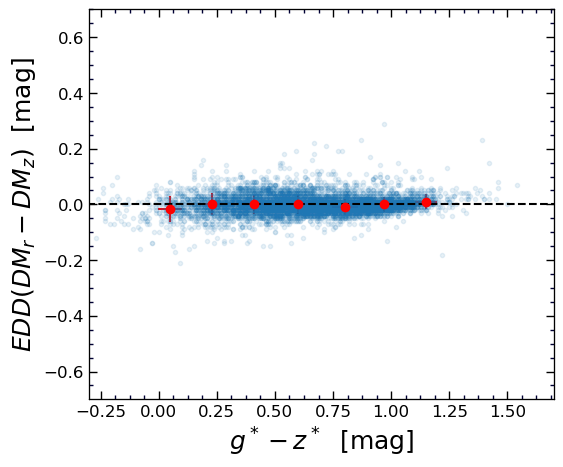

In [29]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-zzz[indx] # logWimx[indx] #
Y = DMr[indx]-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-z^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_z)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

0.04999999999999982 0.9549925860214447
0.22999999999999865 0.9772372209558151
0.41000000000000014 1.0
0.6000000000000014 1.0
0.7999999999999989 1.0
0.9700000000000006 1.0232929922807494
1.1500000000000004 1.0471285480508898


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc6475cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc64ba050>)

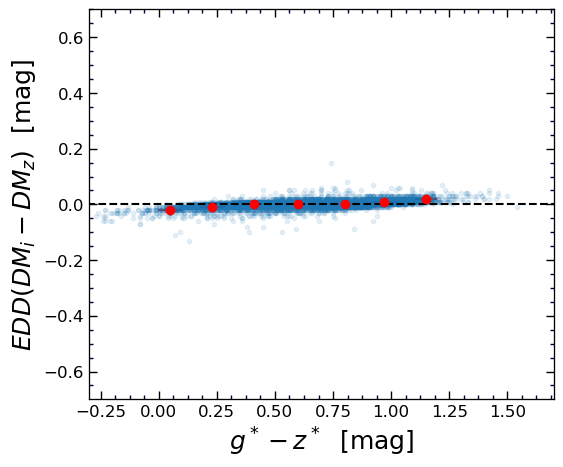

In [30]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-zzz[indx] # logWimx[indx] #
Y = DMi[indx]-DMz[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.1,1.3, 0.20):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), 10**np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.3,1.7)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-z^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

-0.030000000000001137 0.3399999999999963
0.07000000000000028 0.16499999999999737
0.15500000000000025 0.120000000000001
0.2599999999999998 0.0800000000000054
0.35999999999999943 0.05000000000000426
0.4599999999999991 0.020000000000003126
0.5500000000000007 0.0
0.6499999999999986 -0.01999999999999602
0.75 -0.020000000000003126
0.8300000000000001 -0.010000000000005116
0.9299999999999997 -0.12500000000000178
1.0299999999999994 -0.060000000000002274
1.1400000000000006 -0.1999999999999993
1.2199999999999989 -0.6899999999999977


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc6171e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc61e5090>)

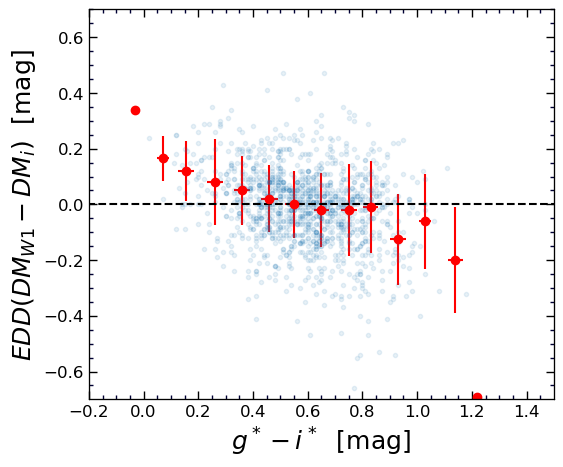

In [31]:
DMr  = table['DMr']
DMi  = table['DMi']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) &
                 (Wqlt>3) & (w11>0) &(logWimx<2.6) &(logWimx>2.2))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  ggg[indx]-iii[indx] # logWimx[indx] #
Y = DM_w1[indx]-DMi[indx]

ax.plot(X, Y, '.', alpha=0.1)

# for i in np.arange(-1.8,2.8, 0.2):
for i in np.arange(-0.2,1.5, 0.10):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.10:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print np.median(xp), np.median(yp)

ax.plot([-3,3], [0,0], 'k--')
ax.set_xlim(-0.2,1.5)
ax.set_ylim(-0.7,0.7)

ax.set_xlabel(r'$g^*-i^* $'+'  [mag]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 
set_axes(ax, fontsize=12)

In [32]:
np.median(DMi[indx]-DMz[indx])

0.0

[-2.83960708e-06  1.70625064e-02]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc5e42a90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc5eb8d10>)

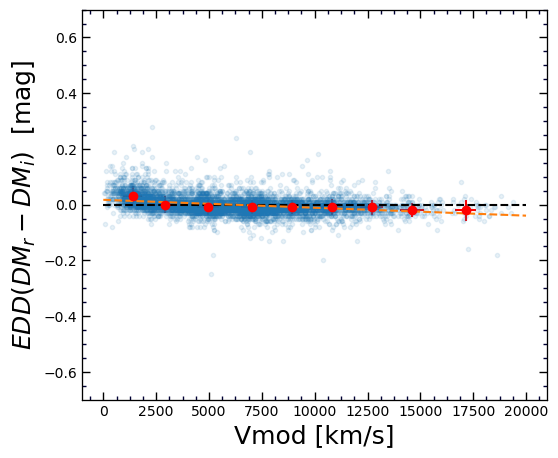

In [33]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & 
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vmod[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


v = np.linspace(0,20000,2000)
c = np.polyfit(X,Y, 1)
ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

[6.71831569e-08 4.83382763e-04]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc6894c10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc5ec2050>)

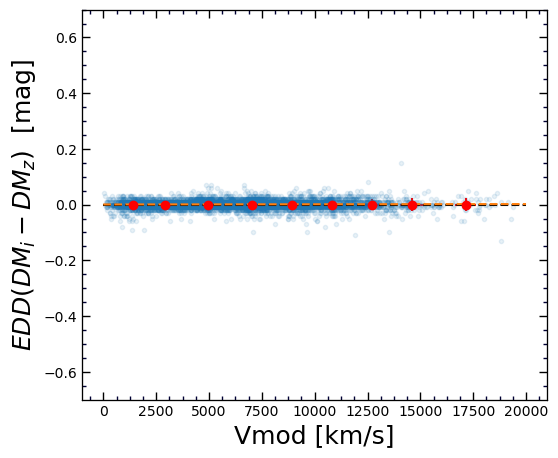

In [34]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & 
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vmod[indx] #
Y = (DMi[indx])-DMz[indx]
Ye = np.sqrt(dDMi**2+dDMz**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


v = np.linspace(0,20000,2000)
c = np.polyfit(X,Y, 1)
ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel('Vmod [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

0.0
-0.0062836258636493805


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc7054910>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc7110d50>)

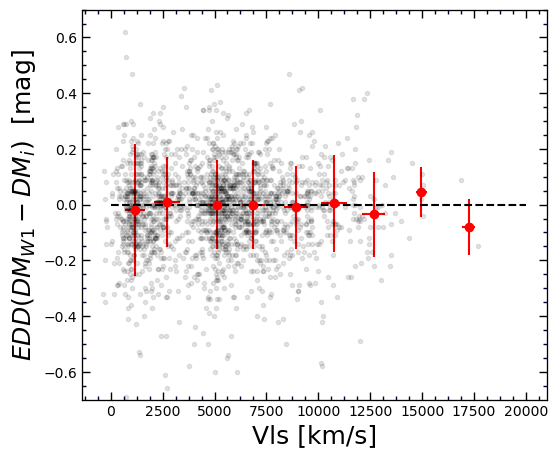

In [35]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
Vls   = table['Vls']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0) & (logWimx<3) & (logWimx>0) )


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vls[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    ype  = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>0:
        yp = np.asarray(yp)
        ype = np.asarray(ype)
        yy = np.median(yp)  #    np.sum(yp/ype)/np.sum(1./ype) # 
        ax.errorbar(np.median(xp), yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


# v = np.linspace(0,20000,2000)
# c = np.polyfit(X,Y, 1)
# ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)

# c = np.polyfit(X,Y, 0, w=1./Ye)
# ax.plot(v, v*0+c[0], '--')


ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print  np.sum(Y/Ye)/np.sum(1./Ye)

set_axes(ax, fontsize=10)

In [36]:
indx, = np.where((zzz>0) & (Sqlt>3) & (Wqlt>3) & (Vmod<20000))
Y = DM_w1[indx]-DMz[indx]
Ye = np.sqrt(dDM_w1[indx]**2+dDMz[indx]**2)
print np.sum(Y/Ye)/np.sum(1./Ye)
np.median(Y), np.mean(Y), np.std(Y)

-0.00848916156184314


(0.0, -0.01693967631191763, 0.1853651190397987)

0.0
[ 0.00382492 -0.01464247  0.01286208]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc7dad690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc73ae310>)

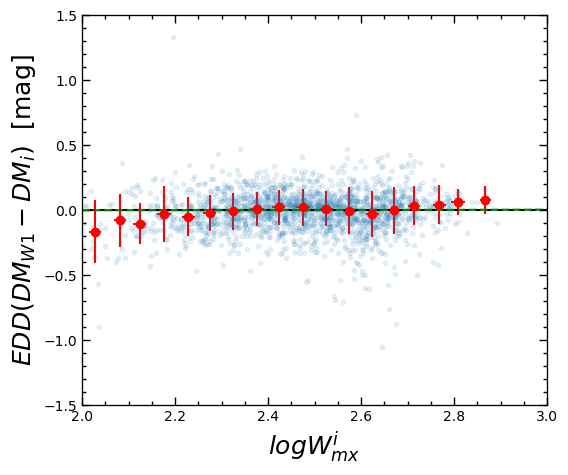

In [37]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']
dDMz = table['P0']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X[(X>2.0)&(X<2.9)],Y[(X>2.0)&(X<2.9)], 3, w=1./Ye[(X>2.0)&(X<2.9)])
# ax.plot(v,c[0]*v**3+c[1]*v**2+c[2]*v+c[3], 'r--')

c = np.polyfit(X, Y, 2, w=1./Ye)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'g--')



ax.set_ylim(-1.5,1.5)

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print c
set_axes(ax, fontsize=10)

0.0
-0.0062836258636493805


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcccfa95f90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc6d4d650>)

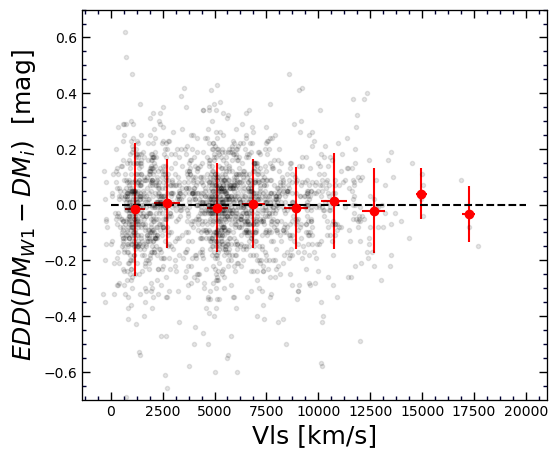

In [38]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X =  Vls[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(0,18000, 2000):
    xp = []
    yp = []
    ype  = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+2000:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>0:
        yp = np.asarray(yp)
        ype = np.asarray(ype)
        yy =  np.sum(yp/ype)/np.sum(1./ype) # np.median(yp)  #
        ax.errorbar(np.median(xp), yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
# ax.set_xlim(0,1.5)


# v = np.linspace(0,20000,2000)
# c = np.polyfit(X,Y, 1)
# ax.plot(v,c[0]*v+c[1], '--')
ax.set_ylim(-0.7,0.7)

# c = np.polyfit(X,Y, 0, w=1./Ye)
# ax.plot(v, v*0+c[0], '--')


ax.set_xlabel('Vls [km/s]', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print  np.sum(Y/Ye)/np.sum(1./Ye)

set_axes(ax, fontsize=10)

In [39]:
np.median(Y)

0.0

0.0
[-0.01301036 -0.03133405  0.02511462]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc7141250>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc7c73290>)

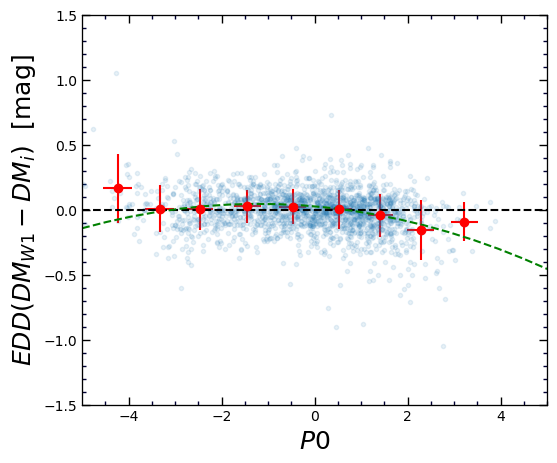

In [40]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']
P0 = table['P0']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = P0[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(-5,5,1):
    xp  = []
    yp  = []
    ype = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
            ype.append(Ye[ii])
    if len(xp)>0:
        yp = np.asarray(yp)
        ype = np.asarray(ype)
        yy =  np.sum(yp/ype)/np.sum(1./ype) # np.median(yp)  #
        ax.errorbar(np.median(xp), yy, yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([-5,5], [0,0], 'k--')
ax.set_xlim(-5,5)


v = np.linspace(-5,5,20)
c = np.polyfit(X[np.abs(X)<4], Y[np.abs(X)<4], 2, w=1./Ye[np.abs(X)<4])
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'g--')



ax.set_ylim(-1.5,1.5)

ax.set_xlabel(r'$P0$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print c
set_axes(ax, fontsize=10)

[ 0.00525833 -0.17710157]
0.0


(-1.5, 1.5)

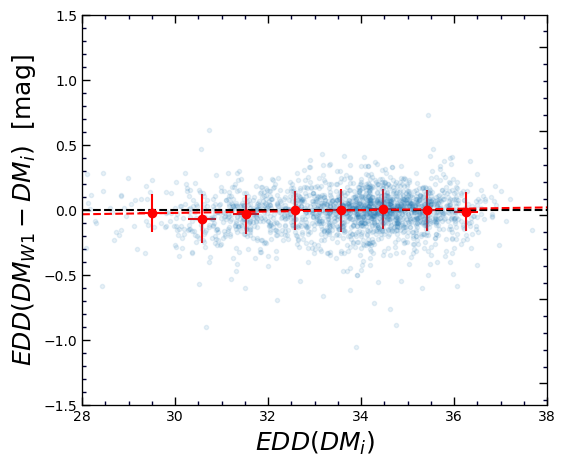

In [41]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMi[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(29,37,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1./Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{i})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)
ax.set_ylim(-1.5,1.5)

[ 0.00499321 -0.31371077  4.89963131]
0.0


(-1.5, 1.5)

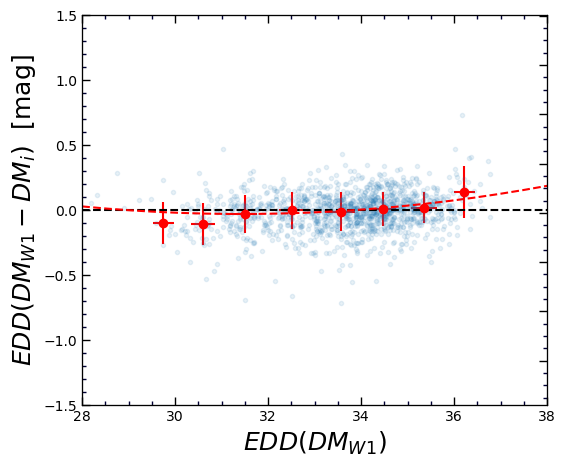

In [42]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0)&(logWimx<2.6) &(logWimx>2.2))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DM_w1[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(29,37,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 2, w=1./Ye)
ax.plot(v,m[0]*v**2+m[1]*v+m[2], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{W1})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)
ax.set_ylim(-1.5,1.5)

[-0.39035815 -0.1957322 ]
0.0


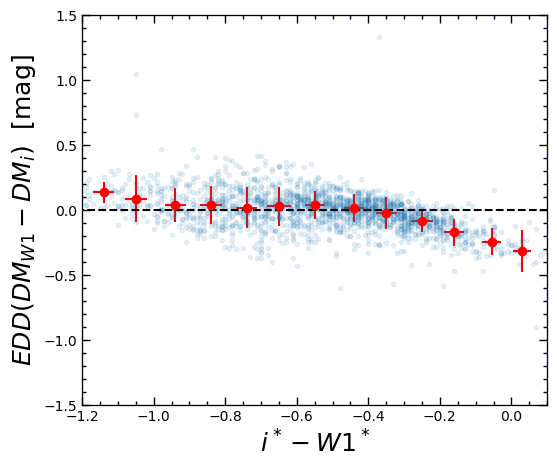

In [43]:
DMr  = table['DMr']
DMz  = table['DMz']
DMi  = table['DMi']

DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & (Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0) & (keep==1))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = iii[indx]-w11[indx] #
Y = (DM_w1[indx])-DMi[indx]
Ye = np.sqrt(dDM_w1**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(-1.2,0.1,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(-1.2,0.1)
ax.set_ylim(-1.5,1.5)

v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1./Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$i^*-W1^*$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{W1}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
set_axes(ax, fontsize=10)

ax.plot([-2,2], [0,0], 'k--')

[-0.00594037  0.20090859]
0.0
[-0.00594037  0.20090859]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcccc79fbd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc73dc890>)

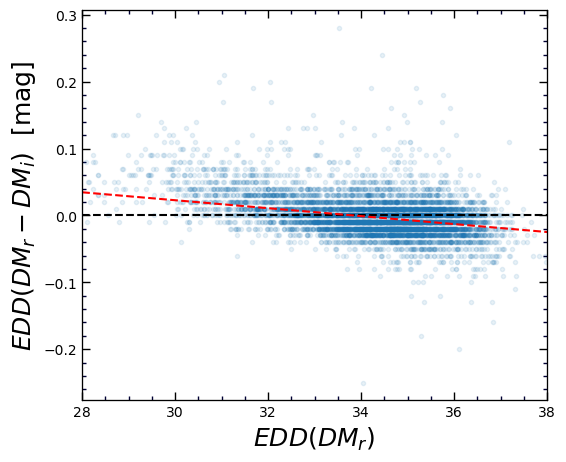

In [44]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMr[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1/Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{r})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print m
set_axes(ax, fontsize=10)

[ 1.66792401e-05 -6.13951984e-04]
0.0
[ 1.66792401e-05 -6.13951984e-04]


(<matplotlib.axes._subplots.AxesSubplot at 0x7fcccc092890>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcccc223dd0>)

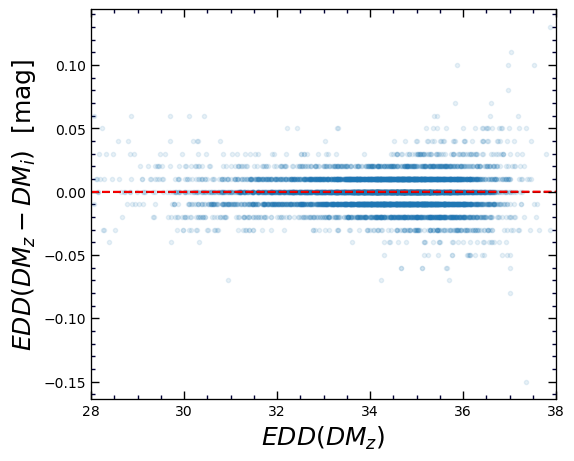

In [45]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = DMz[indx] #
Y = (DMz[indx])-DMi[indx]
Ye = np.sqrt(dDMz**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([28,38], [0,0], 'k--')
ax.set_xlim(28,38)


v = np.linspace(28,38,20)
m = np.polyfit(X, Y, 1, w=1/Ye)
ax.plot(v,m[0]*v+m[1], 'r--')
# ax.set_ylim(-0.7,0.7)

print m
ax.set_xlabel(r'$EDD(DM_{z})$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{z}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)
print m
set_axes(ax, fontsize=10)

[ 0.06997855 -0.39236653  0.53533206]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc79dee90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc7a53810>)

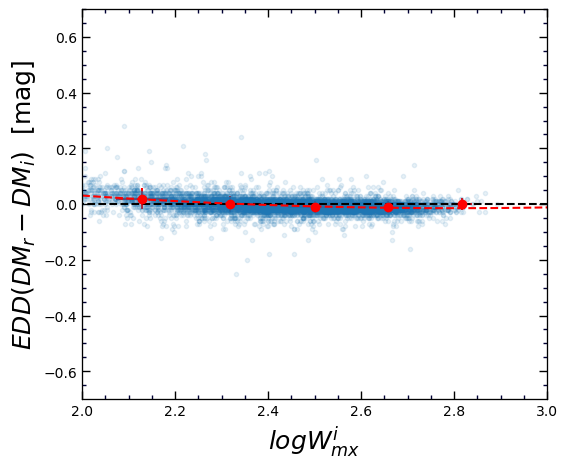

In [46]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DMr[indx])-DMi[indx]
Ye = np.sqrt(dDMr**2+dDMi**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X,Y, 2)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'r--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{r}-DM_i)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)

[-0.02867311  0.1391754  -0.16666698]
0.0


(<matplotlib.axes._subplots.AxesSubplot at 0x7fccc6e6ac90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc7e9f710>)

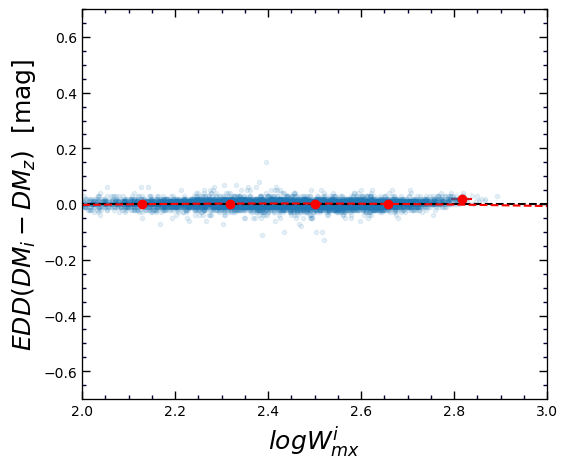

In [47]:
DMr  = table['DMr']
DMz  = table['DMz']
DM_w1  = table['DM_w1']
Vmod   = table['Vmod']
dDM_w1 = table['dDM_w1']
dDMr = table['dDMr']
dDMi = table['dDMi']
dDMz = table['dDMz']

indx, = np.where((ggg>0) & (rrr>0) & (zzz>0) & (iii>0) & (Sqlt>3) & (keep==1) & #(Wqlt>3) & (w11>0) &
                  (Vmod<20000)& (Vmod>0))

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = logWimx[indx] #
Y = (DMi[indx])-DMz[indx]
Ye = np.sqrt(dDMi**2+dDMz**2)
Ye = Ye[indx]

ax.plot(X, Y, '.', alpha=0.1)

for i in np.arange(2, 3.0,.2):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.20:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
#         print np.median(xp), 10**np.median(yp)

ax.plot([0, 20000], [0,0], 'k--')
ax.set_xlim(2,3)


v = np.linspace(2, 3,20)
c = np.polyfit(X,Y, 2)
ax.plot(v,c[0]*v**2+c[1]*v+c[2], 'r--')
ax.set_ylim(-0.7,0.7)
print c

ax.set_xlabel(r'$logW^i_{mx}$', fontsize=18) 
ax.set_ylabel(r'$EDD(DM_{i}-DM_z)$'+'  [mag]', fontsize=18) 

print np.median(Y)

set_axes(ax, fontsize=10)